In [1]:
import numpy as np
import pandas as pd
import pysindy as psd
import do_mpc
from Data_Cleaner import data_loader_main
from SINDy import SINDy_Dynamics
from MPC_Controller import Flow_Dynamics_Model, MPC_Controller

In [2]:
flow_all, _, _, flow_dt, _, _ = data_loader_main(csv_dict='Sim_Results/Ramp_ALIANA')

# import ramp metering data
control_input = pd.read_csv('Results/Meter_Rate.csv')

# remove the first 5 seconds
flow_all = flow_all.iloc[5:, :].reset_index(drop=True)
flow_dt = flow_dt.iloc[5:, :].reset_index(drop=True)
control_input = control_input.iloc[5:, :].reset_index(drop=True)

In [3]:
equations = SINDy_Dynamics(x=flow_all, dx=flow_dt, u= control_input)

In [4]:
# configure dynamics model
model = Flow_Dynamics_Model(equations)

In [5]:
# configure MPC Contorller
mpc = MPC_Controller(model, silence_solver=False)

In [6]:
x_0 = np.array(flow_all.iloc[60,:])

In [7]:
mpc.x0 = x_0

In [8]:
mpc.set_initial_guess()

In [17]:
x_t = np.array(flow_all.iloc[160,:])

In [18]:
u_0 = mpc.make_step(x_t)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      962
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      670

Total number of variables............................:      152
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       88
                     variables with only upper bounds:        0
Total number of equality constraints.................:      104
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.5899820e+02 5.45e+06 3.68e-06  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [11]:
u_0

array([[ 621.44455814],
       [1537.0312677 ],
       [1174.30088999],
       [1279.49379803],
       [ 952.92530701],
       [ 627.21830127],
       [ 379.32341257],
       [ 689.01645498]])

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

In [14]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
# sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [15]:
%%capture
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [16]:
%%capture
for g in [mpc_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name='x0', axis=ax[0])
    g.add_line(var_type='_x', var_name='x1', axis=ax[0])
    g.add_line(var_type='_x', var_name='x2', axis=ax[0])
    g.add_line(var_type='_x', var_name='x3', axis=ax[0])
    g.add_line(var_type='_x', var_name='x4', axis=ax[0])
    g.add_line(var_type='_x', var_name='x5', axis=ax[0])
    g.add_line(var_type='_x', var_name='x6', axis=ax[0])
    g.add_line(var_type='_x', var_name='x7', axis=ax[0])
    

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name='u0', axis=ax[1])
    g.add_line(var_type='_u', var_name='u1', axis=ax[1])
    g.add_line(var_type='_u', var_name='u2', axis=ax[1])
    g.add_line(var_type='_u', var_name='u3', axis=ax[1])
    g.add_line(var_type='_u', var_name='u4', axis=ax[1])
    g.add_line(var_type='_u', var_name='u5', axis=ax[1])
    g.add_line(var_type='_u', var_name='u6', axis=ax[1])
    g.add_line(var_type='_u', var_name='u7', axis=ax[1])


ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[1].set_xlabel('time [min]')

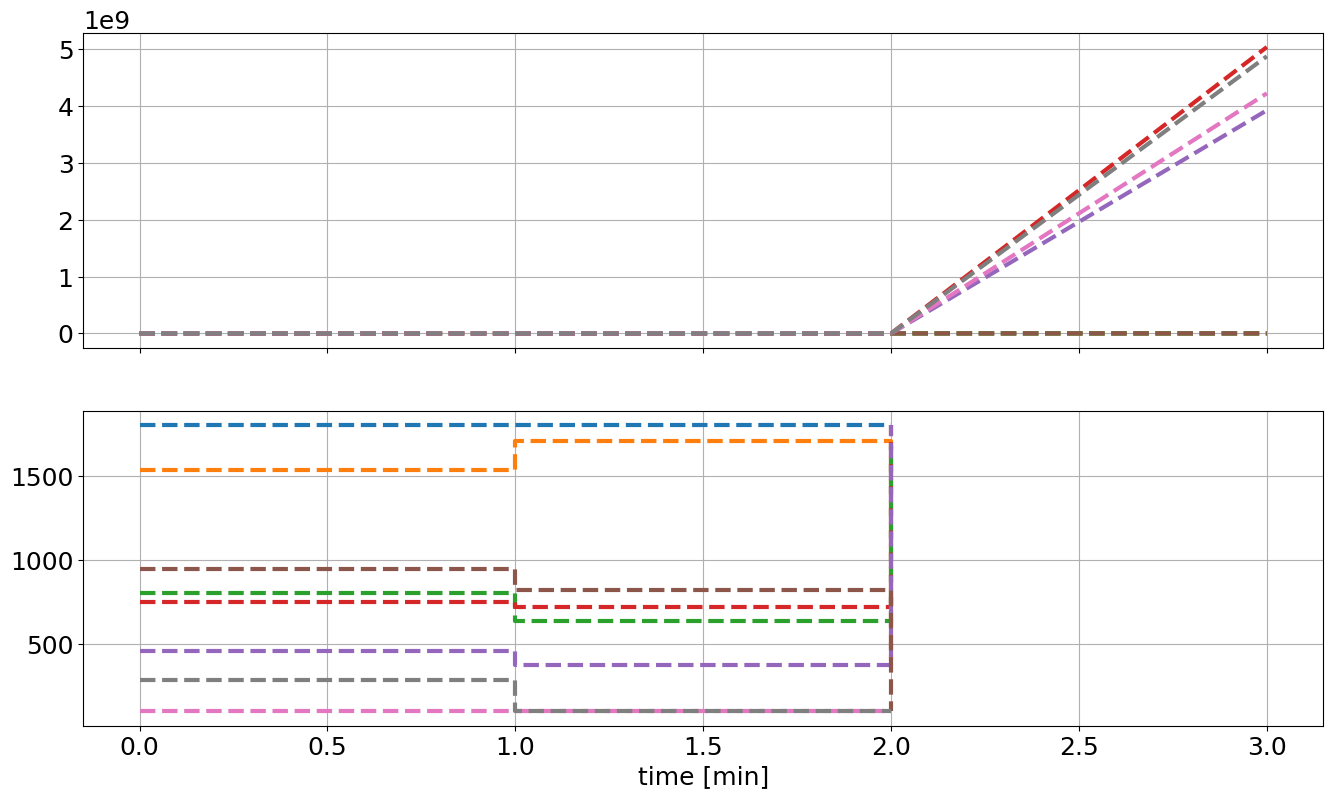

In [17]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig